In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt  # Also needed for plt.title()

DESCRIPTIVE STATISTICS

In [2]:
df=pd.read_csv("C:/Users/Student/Documents/kaim documents/week 1/raw_analyst_ratings.csv/raw_analyst_ratings.csv")
df['headline_length'] = df['headline'].str.len()
print(df['headline_length'].describe())

count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


Text(0.5, 1.0, 'Distribution of Headline Length')

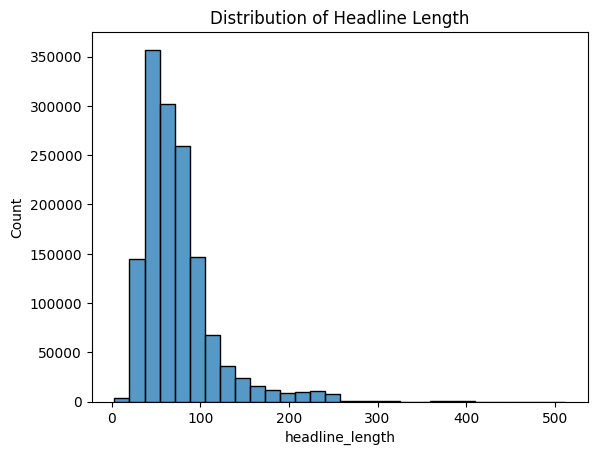

In [3]:
sns.histplot(df['headline_length'], bins=30)
plt.title('Distribution of Headline Length')


In [4]:
publisher_counts = df['publisher'].value_counts()
print(publisher_counts.head(10))

publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


Text(0.5, 1.0, 'Top 10 Most Active Publishers')

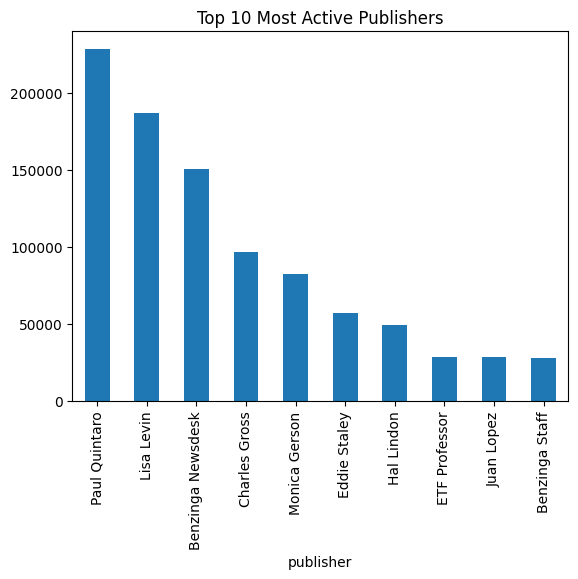

In [5]:
publisher_counts.head(10).plot(kind='bar')
plt.title('Top 10 Most Active Publishers')

In [6]:
df['date'] = pd.to_datetime(df['date'], utc=True, errors='coerce')
df['day_of_week'] = df['date'].dt.day_name()

Text(0.5, 1.0, 'Number of Articles Over Time')

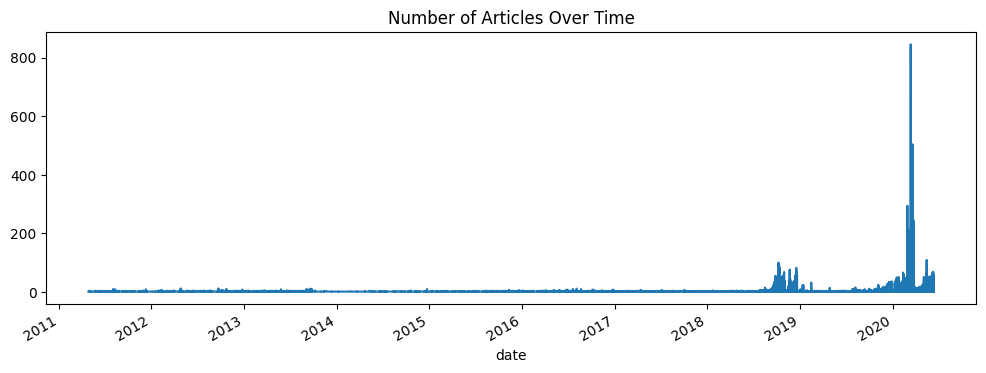

In [7]:
df['date'].value_counts().sort_index().plot(figsize=(12,4))
plt.title('Number of Articles Over Time')

Text(0.5, 1.0, 'Articles by Day of the Week')

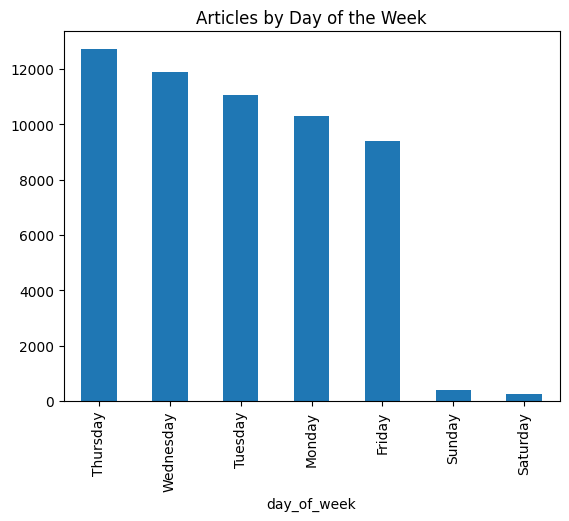

In [8]:
df['day_of_week'].value_counts().plot(kind='bar')
plt.title('Articles by Day of the Week')


TEXT ANALYSIS

In [9]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Student\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [10]:
%pip install gensim nltk pandas

In [11]:
import nltk
import gensim
import pandas as pd
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')  # For tokenization

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Student\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Student\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])  # Add custom stopwords

def preprocess(text):
    return [word for word in simple_preprocess(text) 
            if word not in stop_words and len(word) > 2]

# Apply preprocessing
df['tokens'] = df['headline'].apply(preprocess)

In [13]:
# Create dictionary
dictionary = gensim.corpora.Dictionary(df['tokens'])
dictionary.save('my_dictionary.dict')

# Filter extremes
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Create corpus
corpus = [dictionary.doc2bow(tokens) for tokens in df['tokens']]

In [14]:
import pandas as pd

# Assuming `df` is your DataFrame with a 'text' column
num_docs = len(df)
total_words = df['headline'].apply(lambda x: len(x.split())).sum()
avg_words = total_words / num_docs

print(f"Documents: {num_docs:,}")
print(f"Total words: {total_words:,}")
print(f"Avg. words/doc: {avg_words:.1f}")

Documents: 1,407,328
Total words: 16,067,050
Avg. words/doc: 11.4


In [15]:
import psutil
print(f"RAM used: {psutil.virtual_memory().percent}%")

RAM used: 87.3%


In [16]:
import os
import psutil

# Get logical cores (including hyper-threading)
logical_cores = os.cpu_count()  

# Get physical cores (excludes hyper-threading)
physical_cores = psutil.cpu_count(logical=False)

print(f"Logical cores (threads): {logical_cores}")
print(f"Physical cores: {physical_cores}")

Logical cores (threads): 12
Physical cores: 10


In [17]:
from gensim.models import LdaMulticore
from gensim.corpora import Dictionary
import pandas as pd
import numpy as np
import os
import psutil

headlines = df['headline'].astype(str).tolist()

# 2. Preprocessing function
def preprocess(text):
    return simple_preprocess(str(text), deacc=True, min_len=2)

# 3. Load dictionary
dictionary = Dictionary.load('my_dictionary.dict')

# 4. Calculate sample size (200K docs or 15% of data)
total_docs = len(headlines)
sample_size = min(100000, int(total_docs * 0.15))
sample_indices = np.random.choice(total_docs, size=sample_size, replace=False)
sample_corpus = [dictionary.doc2bow(preprocess(headlines[i])) for i in sample_indices]

# 5. Configure parallel training
workers = min(10, os.cpu_count() - 2)  # Uses 10 workers (leaves 2 threads free)
lda_model = LdaMulticore(
    corpus=sample_corpus,
    id2word=dictionary,
    num_topics=20,              # Increased topics for large dataset
    passes=3,                   # More passes for better quality
    workers=workers,            # Parallel processing
    chunksize=20000,            # Docs per worker
    random_state=42,
    alpha='symmetric',          # Better for parallel
    eta='auto',                 # Auto-optimize word distribution
    batch=False                 # Memory-efficient streaming
)

# 6. Save model
lda_model.save('lda_parallel_model.gensim')

# 7. Print topics
for idx, topic in lda_model.print_topics(-1, num_words=8):
    print(f"Topic {idx}: {topic}")

Topic 0: 0.022*"announces" + 0.009*"downgrades" + 0.008*"inc" + 0.006*"neutral" + 0.006*"reports" + 0.006*"stock" + 0.006*"says" + 0.006*"coverage"
Topic 1: 0.030*"maintains" + 0.030*"target" + 0.029*"price" + 0.025*"raises" + 0.022*"buy" + 0.011*"lowers" + 0.011*"announces" + 0.008*"outperform"
Topic 2: 0.021*"alert" + 0.021*"option" + 0.021*"earnings" + 0.015*"ask" + 0.014*"ref" + 0.012*"market" + 0.012*"calls" + 0.011*"sweep"
Topic 3: 0.024*"market" + 0.022*"shares" + 0.015*"announces" + 0.014*"initiates" + 0.014*"coverage" + 0.013*"update" + 0.012*"buy" + 0.012*"mid"
Topic 4: 0.047*"update" + 0.022*"market" + 0.020*"mid" + 0.017*"morgan" + 0.014*"raises" + 0.013*"markets" + 0.010*"shares" + 0.010*"morning"
Topic 5: 0.044*"top" + 0.041*"benzinga" + 0.032*"upgrades" + 0.028*"downgrades" + 0.013*"reports" + 0.011*"stocks" + 0.008*"eps" + 0.007*"inc"
Topic 6: 0.018*"target" + 0.018*"price" + 0.011*"downgrades" + 0.011*"neutral" + 0.010*"biggest" + 0.009*"changes" + 0.009*"lowers" + 0.0

In [18]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

Time Series Analysis

Text(0.5, 1.0, 'Daily Publication Frequency')

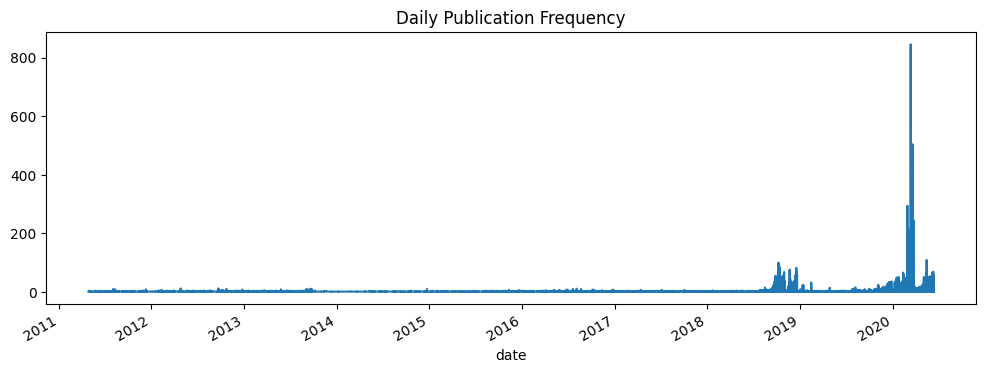

In [19]:
daily_counts = df['date'].value_counts().sort_index()
daily_counts.plot(figsize=(12,4))
plt.title('Daily Publication Frequency')

Text(0.5, 1.0, '7-Day Rolling Average of Publications')

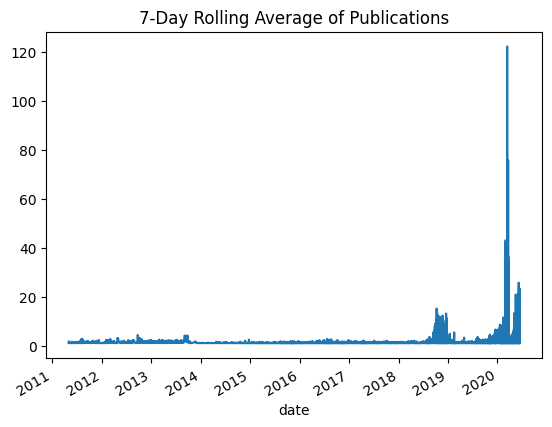

In [20]:
daily_counts.rolling(window=7).mean().plot()
plt.title('7-Day Rolling Average of Publications')


Text(0.5, 1.0, 'Articles Published by Hour')

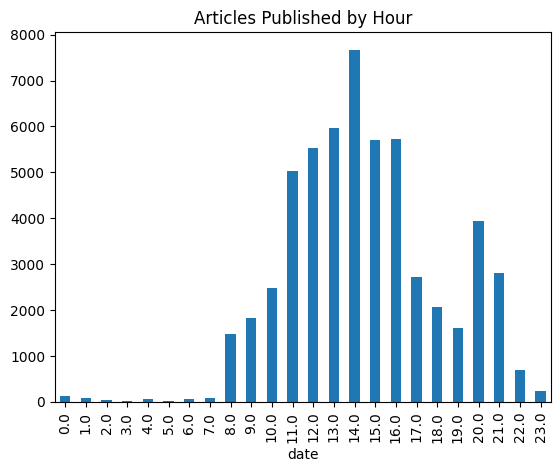

In [21]:
df['date'] = pd.to_datetime(df['date'], format='%H:%M:%S').dt.hour
df['date'].value_counts().sort_index().plot(kind='bar')
plt.title('Articles Published by Hour')


PUBLISHER ANAlYSIS

In [22]:
publisher_counts = df['publisher'].value_counts()
print(publisher_counts.head(10))

publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64
